In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# jt -t monokai -N -T -kl -nfs 10 -tfs 10
from jupyterthemes import jtplot
jtplot.style(theme='monokai')

In light of the past 3 notebooks and in particular of the fresh-realized idea that we don't want to use a sequential model in this case, let's now re-define both data acquisition and the correspongind dataset/loader.

## Data Acquisition

The idea is that now I can just read the piano rolls in their own `npz` format, crop them and convert them to tensors before feeding them to the NN. We don't need the extra steps of converting them to sparse tensors, saving new files, and re-read them from there.

So we'll need a new `csv` with updated information as well.

In [3]:
#export
import os

In [171]:
data_base_path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/data/lpd_5/lpd_5_cleansed/')

In [6]:
paths = []
names = []

# we'll use os.walk again to traverse recursively all directories within base directory
# we'll save a name and a path for each of the found npz files 
# we will then port them as before into a pandas dataframe 
# that ww'll later augment with train/validation and genre informations and export to csv
for r, d, f in os.walk(data_base_path):
    for file in f:
        if '.npz' in file:
            # get the path to file and its name to match in the MSD
            paths.append(os.path.join(r, file))
            names.append(os.path.basename(r))

In [8]:
#export 
import pandas as pd

In [9]:
## Get the combined 5 dataframes with the genres that correspond to `names`
# I need to use a variable number of columsn because that's what they have in the various cls files

# Fields: trackId, genre, minor_genre?
min_colnames=['trackId','genre','min_gen']
csv_cd1 = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_tagtraum_cd1.cls',delimiter = '\t',names=min_colnames)
csv_cd2 = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_tagtraum_cd2c.cls',delimiter = '\t',names=min_colnames)

# Fields: trackId, genre
min_colnames=['trackId','genre']
csv_magd = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd-MAGD-genreAssignment.cls',delimiter = '\t',names=min_colnames)
csv_masd = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd-MASD-styleAssignment.cls',delimiter = '\t',names=min_colnames)

# Fields: trackId, seed-genre, numberOfUserLabels, [label, strength]+
min_colnames=['trackId','genre','min_gen']+[str(i) for i in range(40)]
csv_bea = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_beatunes_map.cls',delimiter = '\t',names=min_colnames)
# Fields: trackId, seed-genre, [label, strength]+
min_colnames=['trackId','genre','min_gen']+[str(i) for i in range(20)]
csv_lastfm = pd.read_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/msd_lastfm_map.cls',delimiter = '\t',names=min_colnames)

In [10]:
# now extract only the names and major genre from each
csv_cd1 = csv_cd1[['trackId','genre']]
csv_cd2 = csv_cd2[['trackId','genre']]
csv_magd = csv_magd[['trackId','genre']]
csv_masd = csv_masd[['trackId','genre']]
csv_bea = csv_bea[['trackId','genre']]
csv_lastfm = csv_lastfm[['trackId','genre']]

In [16]:
# Sadly not all names match, so extract the only the rown for which we have a pianoroll
df = pd.merge(csv_cd1,csv_cd2, on='trackId',how='outer')
df = pd.merge(df,csv_bea,on='trackId',how='outer')
df = pd.merge(df,csv_lastfm,on='trackId',how='outer')
df = pd.merge(df,csv_magd,on='trackId',how='outer')
df = pd.merge(df,csv_masd,on='trackId',how='outer')

df.columns = ['trackId','cd1','cd2','bea','lfm','magd','masd'] # this ordering is explicit as I find these maximise the good label on the left
df = df.loc[df['trackId'].isin(names)]

df = df.astype(str) # makes it easier to post-process, even though not super efficient.
print(df.shape)
df.head()

(18047, 7)


trackId       cd1      cd2      magd               masd  \
7    TRAAAGR128F425B14B  Pop_Rock      Pop  Pop_Rock   Pop_Contemporary   
32   TRAADKW128E079503A  Pop_Rock      nan  Pop_Rock  Rock_Contemporary   
58   TRAAFMT128F429DB58  Pop_Rock      nan  Pop_Rock                nan   
71   TRAAGMC128F4292D0F   Country  Country   Country                nan   
114  TRAALAH128E078234A  Pop_Rock      nan  Pop_Rock   Pop_Contemporary   

         bea      lfm  
7        Pop      pop  
32      Folk      pop  
58       Pop   german  
71   Country  country  
114      Pop     rock

In [17]:
# add column with file path
df.insert(0, "filePath", [ paths[names.index(df.iloc[i,0])] for i in range(len(df))], False) 
df.head()

filePath             trackId  \
7    /home/marco/workspace/musical-genre-from-piano...  TRAAAGR128F425B14B   
32   /home/marco/workspace/musical-genre-from-piano...  TRAADKW128E079503A   
58   /home/marco/workspace/musical-genre-from-piano...  TRAAFMT128F429DB58   
71   /home/marco/workspace/musical-genre-from-piano...  TRAAGMC128F4292D0F   
114  /home/marco/workspace/musical-genre-from-piano...  TRAALAH128E078234A   

          cd1      cd2      magd               masd      bea      lfm  
7    Pop_Rock      Pop  Pop_Rock   Pop_Contemporary      Pop      pop  
32   Pop_Rock      nan  Pop_Rock  Rock_Contemporary     Folk      pop  
58   Pop_Rock      nan  Pop_Rock                nan      Pop   german  
71    Country  Country   Country                nan  Country  country  
114  Pop_Rock      nan  Pop_Rock   Pop_Contemporary      Pop     rock

#### Clean-up the labels so that we get a unique label for each song

based on consensus (and standardized)

* because inserting underscores is harder than removing them, I'm mergin all the words toghether
* setting everything to lowercase and a few other pre-processes

In [18]:
for i in range(len(df)):
    for j in range(2,8):
        df.iloc[i,j] = df.iloc[i,j].replace('_', '').replace('-', '').replace(' ', '').replace('/', '').replace(',', '').lower()

In [55]:
df.head(20)

filePath             trackId  \
7    /home/marco/workspace/musical-genre-from-piano...  TRAAAGR128F425B14B   
32   /home/marco/workspace/musical-genre-from-piano...  TRAADKW128E079503A   
58   /home/marco/workspace/musical-genre-from-piano...  TRAAFMT128F429DB58   
71   /home/marco/workspace/musical-genre-from-piano...  TRAAGMC128F4292D0F   
114  /home/marco/workspace/musical-genre-from-piano...  TRAALAH128E078234A   
141  /home/marco/workspace/musical-genre-from-piano...  TRAANTZ128E0792529   
143  /home/marco/workspace/musical-genre-from-piano...  TRAANZE128F148BF55   
188  /home/marco/workspace/musical-genre-from-piano...  TRAASFP128F42980BD   
256  /home/marco/workspace/musical-genre-from-piano...  TRAAZVG128F425A9BD   
258  /home/marco/workspace/musical-genre-from-piano...  TRABAFJ128F42AF24E   
309  /home/marco/workspace/musical-genre-from-piano...  TRABGCD128F42884EB   
324  /home/marco/workspace/musical-genre-from-piano...  TRABHTY12903CCE195   
346  /home/marco/workspace/musical-genre-from-piano...  TRABKUJ128F4292445   
349  /home/marco/workspace/musical-genre-from-piano...  TRABLGN128F933D417   
363  /home/marco/workspace/musical-genre-from-piano...  TRABMFI128F1476F9F   
400  /home/marco/workspace/musical-genre-from-piano...  TRABQUM12903C9A618   
432  /home/marco/workspace/musical-genre-from-piano...  TRABUCZ128F424163A   
441  /home/marco/workspace/musical-genre-from-piano...  TRABVVN12903CB6445   
520  /home/marco/workspace/musical-genre-from-piano...  TRACDHB12903CDF8F6   
523  /home/marco/workspace/musical-genre-from-piano...  TRACDLP12903CBE918   

            cd1         cd2         bea         lfm        magd  \
7       poprock         pop         pop         pop     poprock   
32      poprock         nan        folk         pop     poprock   
58      poprock         nan         pop      german     poprock   
71      country     country     country     country     country   
114     poprock         nan         pop        rock     poprock   
141     poprock         nan  electronic        dark     poprock   
143     poprock         pop         pop         pop     poprock   
188  electronic         nan         pop  electronic  electronic   
256     poprock         pop         pop         pop     poprock   
258     poprock         pop         pop         pop     poprock   
309     poprock         pop         pop         pop     poprock   
324     poprock         nan        rock       blues     poprock   
346     poprock         nan         pop       latin     poprock   
349     poprock         nan         pop        rock     poprock   
363     poprock        rock        rock        rock     poprock   
400     poprock        rock        rock        rock     poprock   
432     poprock        rock        rock        rock     poprock   
441     poprock        rock        rock   latenight     poprock   
520  electronic  electronic  electronic  electronic  electronic   
523     poprock         pop         pop         pop     poprock   

                 masd  
7     popcontemporary  
32   rockcontemporary  
58                nan  
71                nan  
114   popcontemporary  
141               nan  
143   popcontemporary  
188       electronica  
256             dance  
258   popcontemporary  
309   popcontemporary  
324               nan  
346   popcontemporary  
349  rockcontemporary  
363          popindie  
400  metalalternative  
432  metalalternative  
441               nan  
520               nan  
523   popcontemporary

In [56]:
# now build the consensus
from collections import Counter 

def genre_consensus(genre_list):
    genre_dict = Counter(filter(lambda x: x != 'nan', genre_list))
    return max(genre_dict, key=(lambda key: genre_dict[key])) # if parity, choose the first match, i.e. order or cls matters

In [85]:
target = [genre_consensus(df.iloc[i,range(2,8)]) for i in range(len(df))]

In [86]:
cc = Counter(target)
print(cc)

Counter({'rock': 4175, 'pop': 3422, 'poprock': 1677, 'electronic': 1139, 'country': 1074, 'dance': 558, 'latin': 517, 'r&b': 446, 'jazz': 442, 'rnb': 361, 'house': 263, 'soundtrack': 259, 'hiphop': 239, 'trance': 220, 'classical': 204, 'easylistening': 193, 'electronicadance': 181, 'reggae': 139, 'folk': 128, 'world': 126, 'gospel&religious': 123, 'newage': 122, 'rap': 106, 'metal': 101, 'other': 100, 'techno': 98, 'christmas': 95, 'international': 76, 'instrumental': 60, "children'smusic": 55, 'blues': 53, 'soul': 32, 'religious': 29, 'vocal': 27, 'comedy': 26, 'oldies': 23, 'instrumentals': 23, 'gospel': 16, 'cover': 12, 'infantil': 12, 'german': 12, 'love': 12, 'chillout': 11, 'lofi': 11, 'freestyle': 11, 'party': 10, 'lounge': 9, 'hardcore': 9, 'hitsingles': 9, 'french': 8, 'svensktaggradio': 8, 'finnish': 8, 'spanishpop': 8, 'mpb': 8, 'drum&bass': 8, '6070': 7, 'iskelma': 7, 'stage': 6, 'books&spoken': 6, 'singersongwriter': 6, 'dubstep': 6, 'fitness&workout': 6, 'schoenemusik': 6

interestingly there's a genre called
`vocalsthatshouldbelongtoawomenbutthevocalsaredonebyadudeandsinceivemettheguythathasdonethevocalsandsincehesaniceguyiprobablyshouldntbedissinghissingingyo`, *i.e.*
vocals that should belong to a women but the vocals are done by a dude and since ive met the guy that has done the vocals and since hes a nice guy i probably shouldnt be dissing his singing yo. 

... ok.

So we need a few extra rules to exclude genres that are far too infrequent as they're probably mis-classified.
Also, just by looking at the data, we can merge a few genres that are simply spelled differently (like 'r&b' and 'rnb')

In [87]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [88]:
# unify gospels
idx = indices(target,"gospel&religious")
for i in idx:
    target[i] = 'gospel'    
    
# RnB
idx = indices(target,"r&b")
for i in idx:
    target[i] = 'rnb'

# unify jazz variants
idx = [i for i,t in enumerate(target) if 'jazz' in t]
for i in idx:
    target[i] = 'jazz'
    
# unify soundtrack variants
idx = [i for i,t in enumerate(target) if 'soundtrack' in t]
for i in idx:
    target[i] = 'soundtrack'
    
idx = [i for i,t in enumerate(target) if 'film' in t]
for i in idx:
    target[i] = 'soundtrack'    

idx = [i for i,t in enumerate(target) if 'composer' in t]
for i in idx:
    target[i] = 'soundtrack'    
    
    
# comedy (should this even be part??)    
idx = indices(target,"comedyspoken")
for i in idx:
    target[i] = 'comedy'

#children'smusic and children can be united +  a few others
idx = indices(target,"children'smusic")
for i in idx:
    target[i] = 'children'
    
idx = indices(target,"infantil")
for i in idx:
    target[i] = 'children'
    
idx = indices(target,"electronicadance")
for i in idx:
    target[i] = 'electronic'
    
idx = indices(target,"international")
for i in idx:
    target[i] = 'world'
    
target[target.index('queen')] = 'rock'
target[target.index('deeppurple')] = 'rock'
target[target.index('clasica')] = 'classical'
target[target.index('sebastianbach')] = 'classical'
target[target.index('greenday')] = 'poprock'
target[target.index('rockpunk')] = 'poprock'
target[target.index('rapfrancais')] = 'rap'
target[target.index('francehiphoprap')] = 'rap'

In [90]:
# what is stage?
idx = indices(target,"stage")
df.iloc[idx]
# it's probably live music, but it's hard to discern that from a MIDI ... google doesn't seem to help.

filePath             trackId  \
245465  /home/marco/workspace/musical-genre-from-piano...  TRBLKMQ128F4265A45   
270610  /home/marco/workspace/musical-genre-from-piano...  TRDVOMC12903CD1DEB   
340238  /home/marco/workspace/musical-genre-from-piano...  TRKJOSJ128F92E462C   
394444  /home/marco/workspace/musical-genre-from-piano...  TRPIYNS128F92C8272   
422077  /home/marco/workspace/musical-genre-from-piano...  TRRWXII128F42A46D3   
424673  /home/marco/workspace/musical-genre-from-piano...  TRSDCJR128F933A211   

        cd1  cd2  bea  lfm   magd masd  
245465  nan  nan  nan  nan  stage  nan  
270610  nan  nan  nan  nan  stage  nan  
340238  nan  nan  nan  nan  stage  nan  
394444  nan  nan  nan  nan  stage  nan  
422077  nan  nan  nan  nan  stage  nan  
424673  nan  nan  nan  nan  stage  nan

In [91]:
# what is cover?
idx = indices(target,"cover")
df.iloc[idx]
# apparently poprock for the first few, the other probably to be deleted as well...
for i in idx[:4]:
    target[i] = 'poprock'

In [92]:
idx = indices(target,"italian")
# df.iloc[idx]
for i in idx[:2]:
    target[i] = 'poprock'

idx = indices(target,"french")
# df.iloc[idx]
target[idx[0]] = 'vocal'
target[idx[1]] = 'poprock'

idx = indices(target,"german")
# df.iloc[idx]
for i in idx[:5]:
    target[i] = 'poprock'

idx = indices(target,"lofi")
for i in idx:
    target[i] = 'chillout'

idx = indices(target,"hitsingles")
# df.iloc[idx]
target[idx[6]] = 'pop'

idx = indices(target,"hitsingles")
# df.iloc[idx]
for i in idx:
    target[i] = 'rock'

idx = indices(target,"svensktaggradio")
# df.iloc[idx]
for i in idx[:6]:
    target[i] = 'poprock'

idx = indices(target,"finnish")
# df.iloc[idx]
target[idx[0]] = 'poprock'

idx = indices(target,"spanishpop")
# df.iloc[idx]
for i in idx:
    target[i] = 'pop'
    
idx = indices(target,'mpb')
# df.iloc[idx]
for i in idx:
    target[i] = 'latin'

In [93]:
# re-examine the labels
cc = Counter(target)
print(cc)

Counter({'rock': 4185, 'pop': 3431, 'poprock': 1698, 'electronic': 1320, 'country': 1074, 'rnb': 807, 'dance': 558, 'latin': 525, 'jazz': 459, 'soundtrack': 265, 'house': 263, 'hiphop': 239, 'trance': 220, 'classical': 206, 'world': 202, 'easylistening': 193, 'reggae': 139, 'gospel': 139, 'folk': 128, 'newage': 122, 'rap': 108, 'metal': 101, 'other': 100, 'techno': 98, 'christmas': 95, 'children': 72, 'instrumental': 60, 'blues': 53, 'soul': 32, 'religious': 29, 'vocal': 28, 'comedy': 26, 'oldies': 23, 'instrumentals': 23, 'chillout': 22, 'love': 12, 'freestyle': 11, 'party': 10, 'lounge': 9, 'hardcore': 9, 'drum&bass': 8, 'cover': 8, '6070': 7, 'finnish': 7, 'german': 7, 'iskelma': 7, 'stage': 6, 'books&spoken': 6, 'singersongwriter': 6, 'dubstep': 6, 'fitness&workout': 6, 'schoenemusik': 6, 'french': 6, 'bachata': 5, 'samba': 5, 'ambient': 5, 'mellow': 5, 'unclassifiable': 5, 'military': 5, 'rocklatino': 5, 'ndw': 4, 'deutscheschlager': 4, 'brasil': 4, 'relax': 4, 'greek': 4, 'christ

In [94]:
idx = indices(target,"rockpopenespanol")
for i in idx:
    target[i] = 'poprock'
    
idx = indices(target,"bachata")
for i in idx:
    target[i] = 'latin'

idx = indices(target,"samba")
for i in idx:
    target[i] = 'latin' 

idx = indices(target,"brasil")
for i in idx:
    target[i] = 'latin' 
    
idx = indices(target,"ambient")
for i in idx:
    target[i] = 'chillout' 
    
idx = indices(target,"mellow")
for i in idx:
    target[i] = 'chillout'
    
idx = indices(target,"italianpop")
for i in idx:
    target[i] = 'pop'  

idx = indices(target,"popespañol")
for i in idx:
    target[i] = 'pop'

In [95]:
## Now restrict only to labels with count greater that 10
counts = dict(Counter(target))
kept_targets = [t for t,c in counts.items() if c > 10]
print(kept_targets)

to_keep = [True  if t in kept_targets else False for t in target]
df.insert(2, "target", target, True) 
df = df.loc[to_keep]
df.head()

['pop', 'poprock', 'country', 'electronic', 'rock', 'latin', 'rnb', 'rap', 'world', 'newage', 'jazz', 'blues', 'reggae', 'folk', 'christmas', 'vocal', 'metal', 'hiphop', 'soundtrack', 'easylistening', 'comedy', 'oldies', 'house', 'dance', 'gospel', 'trance', 'children', 'other', 'techno', 'classical', 'chillout', 'soul', 'religious', 'instrumental', 'instrumentals', 'love', 'freestyle']


filePath   target  \
7    /home/marco/workspace/musical-genre-from-piano...      pop   
32   /home/marco/workspace/musical-genre-from-piano...  poprock   
58   /home/marco/workspace/musical-genre-from-piano...  poprock   
71   /home/marco/workspace/musical-genre-from-piano...  country   
114  /home/marco/workspace/musical-genre-from-piano...  poprock   

                trackId      cd1      cd2      bea      lfm     magd  \
7    TRAAAGR128F425B14B  poprock      pop      pop      pop  poprock   
32   TRAADKW128E079503A  poprock      nan     folk      pop  poprock   
58   TRAAFMT128F429DB58  poprock      nan      pop   german  poprock   
71   TRAAGMC128F4292D0F  country  country  country  country  country   
114  TRAALAH128E078234A  poprock      nan      pop     rock  poprock   

                 masd  
7     popcontemporary  
32   rockcontemporary  
58                nan  
71                nan  
114   popcontemporary

In [116]:
#export 
from random import random,randint

In [99]:
# Add information about train and valid sets
valid_percentage = 0.15
df.insert(0, "valid", [ random()<valid_percentage for _ in range(len(df))], True) 

# # permute the columns
train_valid_df = df.iloc[:,[1,2,3,0]]
train_valid_df.head()

filePath             trackId  \
7    /home/marco/workspace/musical-genre-from-piano...  TRAAAGR128F425B14B   
32   /home/marco/workspace/musical-genre-from-piano...  TRAADKW128E079503A   
58   /home/marco/workspace/musical-genre-from-piano...  TRAAFMT128F429DB58   
71   /home/marco/workspace/musical-genre-from-piano...  TRAAGMC128F4292D0F   
114  /home/marco/workspace/musical-genre-from-piano...  TRAALAH128E078234A   

      target  valid  
7        pop  False  
32   poprock  False  
58   poprock  False  
71   country  False  
114  poprock  False

In [101]:
# Finally save to a csv file
train_valid_df.to_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/train_valid.csv',index=False)

In [103]:
# create the 'test' set for those for which I don't have labels
test_set = [n for n in names if (n not in list(df['trackId']))]
test_df = pd.DataFrame(test_set,columns =['trackId'])
test_df.insert(0, "filePath", [ paths[names.index(test_df.iloc[i,0])] for i in range(len(test_df))], False) 
test_df.head()

filePath             trackId
0  /home/marco/workspace/musical-genre-from-piano...  TRUUICF128F93257EC
1  /home/marco/workspace/musical-genre-from-piano...  TRUUWXO128F14AD734
2  /home/marco/workspace/musical-genre-from-piano...  TRUUHCU128F427DAC5
3  /home/marco/workspace/musical-genre-from-piano...  TRUUGFQ128F4288B58
4  /home/marco/workspace/musical-genre-from-piano...  TRUUOUW12903CB2961

In [105]:
test_df.to_csv('/home/marco/workspace/musical-genre-from-pianorolls/data/test_set.csv',index=False)

## Good, now let's re-create the DataSet and let's define our `crop` transform

In [107]:
#export
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import os
import pandas as pd
import matplotlib.pyplot as plt
import types

In [106]:
#export 
import pypianoroll as pypr

In [114]:
fname = train_valid_df.iloc[0,0]
pr = torch.from_numpy(pypr.load(fname).get_stacked_pianoroll()).permute(2,1,0)
pr.shape, pr.dtype # uint8 makes me hope we're still dealing with byte tensors right now..

(torch.Size([5, 128, 11136]), torch.uint8)

In [136]:
# These will later be added directly into the DataSet class for convenience!
def load_piano_roll(file_name):
    p = pypr.load(file_name)
    p.assign_constant(1.)
    return torch.from_numpy(p.get_stacked_pianoroll()).permute(2,1,0)

In [22]:
#export 
def plot_sample(sample):
    piano_roll, genre = sample
    piano_roll = np.sum(piano_roll, axis=0).transpose(1,0)
    plt.matshow(piano_roll)
    if isinstance(genre,torch.Tensor):
        genre = genre.item()
    plt.title(genre)
    plt.show()

In [23]:
#export 
from torchvision.transforms import Compose
import numpy as np

## define a couple of transforms. we could make either callable classes or simple functions, I'll demonstrate both
def to_torch(sample):
    pianoroll,genre = sample # unpack, because each transform might do stuff on both pianorolls and or labels
    return torch.from_numpy(pianoroll).permute(2,1,0).float(), torch.tensor(genre,dtype=torch.long)

class Crop_to():
    """
    Crop a piano roll length to length
    @param length the desired sequence length of the input piano roll
    """
    def __init__(self,length):
        assert isinstance(length, int)
        self.length = length
    
    def __call__(self,sample):
        pianoroll,genre = sample
        current_length = pianoroll.shape[0]
        end_point = current_length - self.length
        if end_point > 0:
            cut_point = randint(0,end_point)
            pianoroll = pianoroll[cut_point:(cut_point+self.length),:,:] # cut out a piece lengthx128x5
        else:
            pianoroll = np.concatenate((pianoroll,np.zeros((abs(end_point),*pianoroll.shape[1:3]),dtype=np.uint8)),axis=0)
        return pianoroll, genre

In [27]:
transforms = Compose([Crop_to(128),to_torch])

In [151]:
pr_trsf,_ = transforms((pr,0)) # zero is a fictional label
plot_sample((pr_trsf,'pop'))

In [135]:
### Good, let's re-create the dataset then!

In [ ]:
#export
class PianorollDataset(Dataset):
    """
    Piano Roll dataset.
        Usage examples:
            pianoroll_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path)
            valid_pr_ds = PianorollDataset(csv_file='train_valid.csv',base_path=path,valid_set=True)
    """

    def __init__(self, csv_file, base_path, valid_set = False, transform=None):
        """
        Args:
            @param csv_file (string): Path to the csv file with annotations.
            @param base_path (string): Directory with all the images and the csv.
            @param transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(base_path+'/'+csv_file)
        # restrict to the requested set
        self.valid_set = valid_set
        self.df = self.df.loc[self.df['valid']==valid_set]
        self.base_path = base_path
        self.transform = transform
        
        # Now we need to instanciate our vocab from the unique genres
        self.id_to_genre = dict(enumerate(set(self.df['target'])))
        self.genre_to_id = dict([(value, key) for key, value in self.id_to_genre.items()])
        self.df.insert(2,'targetID',[ self.genre_to_id[g] for g in self.df['target'] ],True)
        
    def __len__(self):
        return len(self.df)
    
    def load_piano_roll(self,file_name):
        # return torch.from_numpy(pypr.load(file_name).get_stacked_pianoroll()).permute(2,1,0)
        p = pypr.load(file_name)
        p.assign_constant(1.)
        return p.get_stacked_pianoroll()

    def __getitem__(self, idx):
        if torch.is_tensor(idx): # wait, do we support lists of items?
            idx = idx.tolist()
        if isinstance(idx, list) and len(idx) > 1:
            raise NotImplementedError # .. no
            
        tensor_pr = self.load_piano_roll(self.df.iloc[idx,0])
        genre = self.df.iloc[idx,2]
        
        sample = (tensor_pr,genre)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
#export
PIANOROLL_data_path = os.path.abspath('/home/marco/workspace/musical-genre-from-pianorolls/data')

In [10]:
# Let's check again that everything works
## without transforms
pianoroll_ds = PianorollDataset(csv_file='train_valid.csv',base_path=PIANOROLL_data_path)
len(pianoroll_ds)

14506

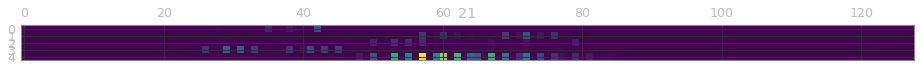

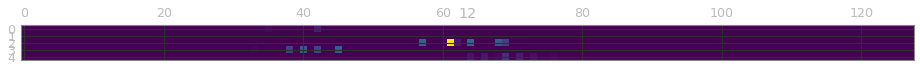

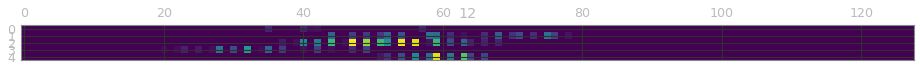

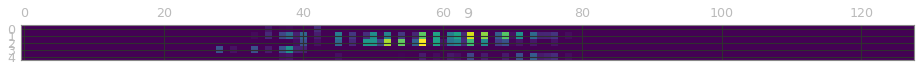

In [24]:
for i in range(len(pianoroll_ds)):
    sample = pianoroll_ds[i]
    plot_sample(sample)

    if i == 3:
        plt.show()
        break

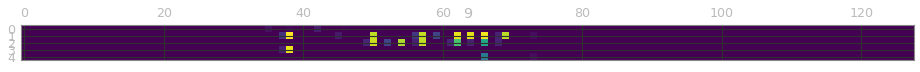

In [29]:
# correctly with transforms
transforms = Compose([Crop_to(128)])
pianoroll_ds = PianorollDataset(csv_file='train_valid.csv',base_path=PIANOROLL_data_path,transform=transforms)

for i in range(len(pianoroll_ds)):
    sample = pianoroll_ds[i]
    plot_sample(sample)

    if i == 3:
        plt.show()
        break

In [30]:
#export

# I'd love for it to show the correct label..
# Util to show a batch
def show_pianoroll_batch(data_loader):
    x,y = next(iter(data_loader))
    for i in range(len(x)):
        plot_sample((x[i],data_loader.dataset.id_to_genre[y[i].item()]))

In [31]:
pianoroll_dl = DataLoader(pianoroll_ds, batch_size=4, shuffle=True, num_workers=4)
pianoroll_dl.dataset

In [32]:
show_pianoroll_batch(pianoroll_dl)   

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 47, in fetch
    return self.collate_fn(data)
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 79, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 64, in default_collate
    return default_collate([torch.as_tensor(b) for b in batch])
  File "/home/marco/.local/lib/python3.6/site-packages/torch/utils/data/_utils/collate.py", line 55, in default_collate
    return torch.stack(batch, 0, out=out)
RuntimeError: Expected object of scalar type Double but got scalar type Byte for sequence element 1 in sequence argument at position #1 'tensors'


In [8]:
!python3 notebook2script.py --fname=4_Data_from_scratch.ipynb --fname_out=pianoroll_data.py

Converted 4_Data_from_scratch.ipynb to exp/pianoroll_data.py
